In [82]:
import ExpNeuron as en

import torch
import torch.nn as nn
import snntorch as snn
import snntorch.functional as snnfunc
import snntorch.spikegen as snngen
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd

In [91]:
class Net(nn.Module):
	def __init__(self, beta = 0.8, threshold = 0.5, membrane_zero = 0.2, membrane_min = 0.0):
		super().__init__()
		self.fll = nn.Linear(4, 4, bias = False)
		self.fsl = en.ExpNeuron(beta = beta, threshold = threshold,
								   	membrane_zero= membrane_zero,
									membrane_min = membrane_min,
									learn_beta= True, 
									learn_threshold= True)
		
		self.sll = nn.Linear(4, 3, bias = False)
		self.ssl = en.ExpNeuron(beta = beta, threshold = threshold,
								   	membrane_zero= membrane_zero,
									membrane_min = membrane_min,
									learn_beta= True, 
									learn_threshold= True,
									learn_membrane_min= True)
		
		# self.fll.weight.data.clamp_(min=0.05)
		# self.sll.weight.data.clamp_(min=0.05)
		
	def forward(self, spk_input):
		mem1 = self.fsl.init_neuron()
		mem2 = self.ssl.init_neuron()

		spk_output = []
		for step in range(spk_input.shape[1]):
			cur1 = self.fll(spk_input.to(torch.float32)[:, step])
			spk1, mem1 = self.fsl(cur1, mem1)
			cur2 = self.sll(spk1)
			spk2, mem2 = self.ssl(cur2, mem2)
			
			spk_output.append(spk2)
		
		return torch.stack(spk_output)

In [97]:
file_path = "../iris_folder/Iris.csv"
df = pd.read_csv(filepath_or_buffer= file_path, sep= ",", header= 0)
df.drop("Id", axis= 1, inplace= True)

# преобразование датафрейма
species = df["Species"].unique()

# При присваивании происходит изменение типа данных на object
for i in range(len(species)):
	df.loc[df["Species"] == species[i], "Species"] = i
df["Species"] = df["Species"].astype("int")

columns_headers = df.columns

# Не учитываю species
for header in columns_headers[:-1]:
	# Нормализую знеачения
	df[header] = df[header] / df[header].max()
# создание датасета для обучения
data = []
num_steps = 100
batch_size = 1

for header in columns_headers:
	data.append(torch.tensor(df[header].values))

# Транспонируем тензор, чтобы иметь features и target каждого образца
data = torch.stack(data, dim = 0).T

trains = snngen.rate(data= data[:, :-1], num_steps= num_steps)

# labels = snngen.targets_rate(data[:, -1], num_classes=3)
labels = data[:, -1]
# Возможно полная хрень. Требует проверки
# Я уверен, что с осями какой-то косяк, так что придется переделывать при плохих результатах обучения
trains = trains.permute(1, 0, 2)
dataset = TensorDataset(trains, labels)
train_data, test_data = random_split(dataset, [0.8, 0.2])
train_data_loader = DataLoader(train_data, shuffle= True, batch_size=batch_size)
test_data_loader = DataLoader(test_data, shuffle= True)
lrng_rt = 5e-3

epochs = 5
net = Net(beta = 0.3, threshold = 0.5, membrane_zero = 0.2, membrane_min = 0.3)
optim = torch.optim.Adam(net.parameters(), lr = lrng_rt, weight_decay= 0.01)
loss_fn = snnfunc.loss.ce_rate_loss()

loss_rec = []

In [98]:
for epoch in range(epochs):
		for trns, lbls in train_data_loader:
				optim.zero_grad()
				outputs = net(trns)
				
				loss = loss_fn(spk_out=outputs, targets= lbls.to(torch.long))
				loss.backward()
				optim.step()

				# with torch.no_grad():
				# 	for param in net.parameters():
				# 		param.clamp_(min=0.05)
				# 	# net.fsl.beta.clamp_(0.09, 0.99)
				# 	# net.fsl.threshold.clamp_(0.15, 0.99)
				# 	# net.ssl.beta.clamp_(0.09, 0.99)
				# 	# net.ssl.threshold.clamp_(0.15, 0.99)


		print((f"Epoch {epoch}, Loss: {loss.item():.4f}"))

		loss_rec.append(loss.item())

# Testing accuracy
data = []
for trn, lbl in test_data_loader:
		prediction = net(trn)
		prediction = torch.mean(input= prediction.unsqueeze(0), dim = 1)

		data.append([prediction.argmax().item(), lbl.item()])
		
data = torch.tensor(data)
accurate = data[(data[:, 0] == data[:, 1]), 0].numel()
accuracy = accurate/data.shape[0]

print((f"accuracy : {accuracy:.2f}"))

for par, val in net.named_parameters():
    print(par, val)

Epoch 0, Loss: 1.0986
Epoch 1, Loss: 0.9130
Epoch 2, Loss: 0.8676
Epoch 3, Loss: 0.8921
Epoch 4, Loss: 0.6556
accuracy : 0.47
fll.weight Parameter containing:
tensor([[ 0.0891,  0.0773,  0.0806,  0.0728],
        [ 0.0288,  0.1513, -0.1855, -0.2760],
        [ 0.0363, -0.1109,  0.2811,  0.3057],
        [ 0.0334,  0.1059, -0.1296, -0.2214]], requires_grad=True)
fsl.threshold Parameter containing:
tensor(0.2541, requires_grad=True)
fsl.beta Parameter containing:
tensor(-0.0194, requires_grad=True)
sll.weight Parameter containing:
tensor([[ 0.1348,  0.8099, -0.2371,  0.2780],
        [-0.0374, -0.0151,  0.2906, -0.2058],
        [ 0.1904, -0.4392,  0.5397, -0.3507]], requires_grad=True)
ssl.threshold Parameter containing:
tensor(0.7402, requires_grad=True)
ssl.beta Parameter containing:
tensor(-0.0315, requires_grad=True)
ssl.membrane_min Parameter containing:
tensor(0.9600, requires_grad=True)


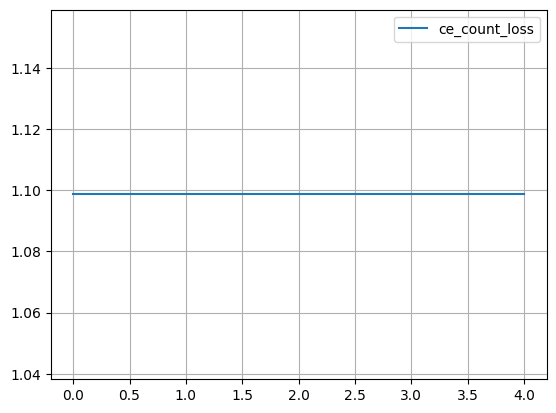

In [86]:
import matplotlib.pyplot as plt

plt.plot(loss_rec, label="ce_count_loss")
plt.legend()
plt.grid()
plt.show()

In [87]:
for par, val in net.named_parameters():
    print(par, val)

# torch.save(net.state_dict(), "fisher_iris_weights.pth")


fll.weight Parameter containing:
tensor([[-0.0697, -0.1095, -0.0711,  0.0617],
        [ 0.4829, -0.0437,  0.2215, -0.6030],
        [-0.2336, -0.1992, -0.1050, -0.3589],
        [ 0.0740, -0.0621,  0.5454,  0.1671]], requires_grad=True)
fsl.threshold Parameter containing:
tensor(0.5789, requires_grad=True)
fsl.beta Parameter containing:
tensor(0.5001, requires_grad=True)
sll.weight Parameter containing:
tensor([[-0.4278,  0.3349,  0.1350, -0.7508],
        [ 0.3771, -0.3173,  0.4108,  0.3493],
        [-0.1897, -0.3212, -0.0506,  0.4172]], requires_grad=True)
ssl.threshold Parameter containing:
tensor(0.1693, requires_grad=True)
ssl.beta Parameter containing:
tensor(0.0622, requires_grad=True)
